# Automated Car Detection - All Damage 50 Epochs

- this method uses the Resnet model architecture
- we train the model and produce weights from our training set
- our 'levers' are the number of epochs, and the number of steps per epoch

- this method also uses transfer learning. i.e. before we do anything we use weights already provided by matterport using coco image database
- this first pass provides distinction between car and other objects, meaning we don't need to train the model to predict where the car is
- coco also provides masks, but not for car damage so we add our own weights by adding training



In [2]:
# Load the libraries
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import cv2
import imgaug,h5py,IPython

import glob
import skimage

# Import Mask RCNN from Matterport
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model
import mrcnn.model as modellib
from mrcnn.model import log
import custom

%matplotlib inline

/Users/chris/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chris/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chris/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chris/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

## Set up the configuration:
- Root directory (this directory)
- MODEL_DIR: directory where the weights from the trained neural nets are stored - one for each epoch
- config: specific configuration for these experiments, held in the custom.py file (in this directory)
- custom_DIR: directory where the training and validation images are stored
- custom_WEIGHTS_PATH: weights file from the training. Select which weight output (h5) to use for prediction

In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()
sys.path.append(ROOT_DIR)  # To find local version of the library
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "custom/")
custom_WEIGHTS_PATH = os.path.join(MODEL_DIR, "damage20200407T1358/mask_rcnn_damage_0050.h5")

## Train the resnet model with our data to get new weights

In [4]:
#!python custom.py train --dataset=custom/ --weights=coco

## Load the training data

- loads the dataset (train in this example) and the annotations file that is associated with the training data
- the annotations contain the x,y coordinates for the mask
- dataset.prepare maps the files to the classes (we only have 2, background BG and damage)

In [5]:
# Load dataset
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 641
Class Count: 2
  0. BG                                                
  1. damage                                            


## Visualize some car damage images and associated masks

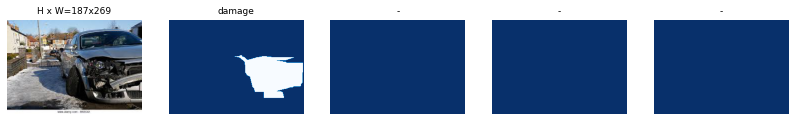

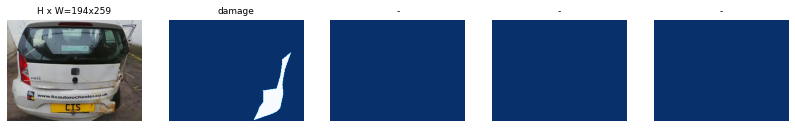

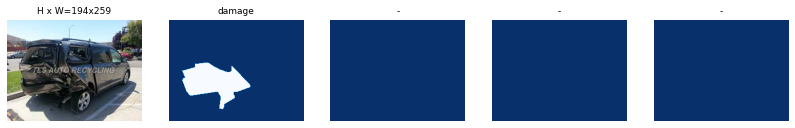

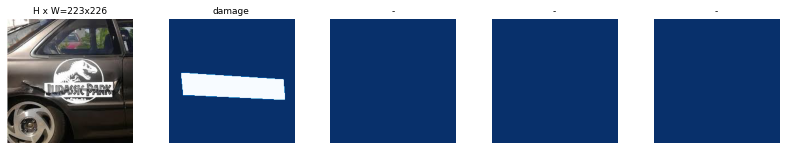

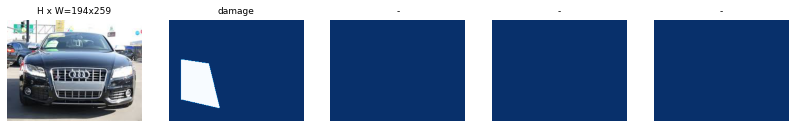

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Check the Bounding Box with annotated damage mask for a typical car image.

image_id  246 /Users/chris/publicRepos/CarDamageMaskRCNN/custom/train/0240.JPEG
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (194, 259, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   42.00000  max:  232.00000  int32


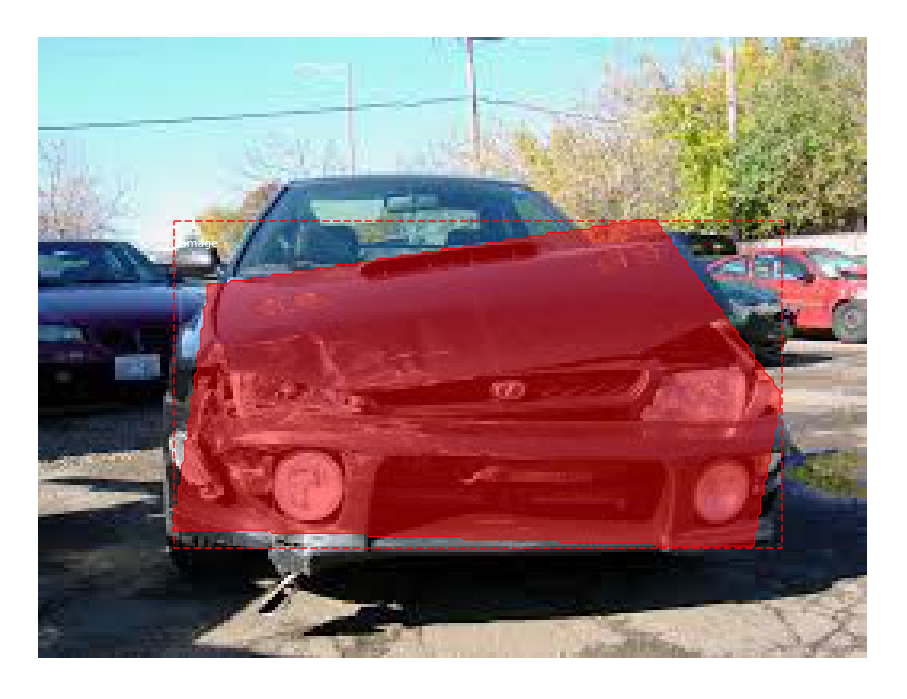

In [8]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Check the components of image annotations. 
- file attributes
- The x and y co-ordinate of all labeled damages('polygon') 
- The class name if exists on the annotation. We did not store these as our images are stored by class, i.e. 

  - body front / rear / side
  - scratch front / rear / side
  - totalled front / rear / side
  - windshield

In [9]:
#Annotation file load
annotations1 = json.load(open(os.path.join(ROOT_DIR, "custom/train/via_region_data.json"),encoding="utf8"))
annotations = list(annotations1.values()) 
annotations = [a for a in annotations if a['regions']]
annotations[0]

{'fileref': '',
 'size': 9234,
 'filename': '0001.JPEG',
 'base64_img_data': '',
 'file_attributes': {},
 'regions': {'0': {'shape_attributes': {'name': 'polygon',
    'all_points_x': [4, 50, 136, 296, 293, 4],
    'all_points_y': [50, 117, 130, 110, 23, 50]},
   'region_attributes': {}}}}

## The x / y coordinates of a mask
- this is what will be predicted

In [10]:
annotations[0]['regions']['0']['shape_attributes']
l = []
for d in annotations[0]['regions']['0']['shape_attributes'].values():
    l.append(d)
display('x co-ordinates of the damage:',l[1])    
display('y co-ordinates of the damage:',l[2])

'x co-ordinates of the damage:'

[4, 50, 136, 296, 293, 4]

'y co-ordinates of the damage:'

[50, 117, 130, 110, 23, 50]

## Model description

For prediction or damage detection we use the model in inference mode. 

- Backbone: CNN architecture name ('resnet101') 
- Min confidence 0.9 (set in config)
- Weights of different loss component
- Mask shape
- Weight Decay
...


In [11]:
config = custom.CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR + "/custom/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Load model weights for prediction

- first create a helper function to visualize results
- create the model with trained weights

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# load the last best model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)    








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /Users/chris/publicRepos/CarDamageMaskRCNN/logs/damage20200407T1358/mask_rcnn_damage_0050.h5
Re-starting from epoch 50


#### Visualize model weight matrix descriptive statistics  

In [13]:
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


## Prediction on all validation images
- does not require annotations to be done
- accuracy is the number of correct predictions out of all files (all of which are damaged with scratches)

In [14]:
import glob
import skimage.draw

results=[]
val_dir = CUSTOM_DIR + 'val/'
filelist = glob.glob(os.path.join(val_dir, '*.JPEG')) 
filelist.sort()

for i, image_path in enumerate(filelist):
    image = skimage.io.imread(image_path)
    
    # Run object detection
    result = model.detect([image])
    results.append(result)

pos_preds = 0
for i in range(len(results)):
    print((filelist[i][-9:]), ": Class = ",results[i][0].get("class_ids", 0), "  ", "Score = ",results[i][0].get("scores", 0))
    if len(results[i][0].get("class_ids", 0)) >0: pos_preds+=1
        
print ("number of images validated =", len(results))        
print ("accuracy =", pos_preds/len(results))    

0112.JPEG : Class =  [1]    Score =  [0.9909648]
0285.JPEG : Class =  [1]    Score =  [0.9586925]
0465.JPEG : Class =  [1 1 1]    Score =  [0.9793833 0.9654278 0.9408958]
0498.JPEG : Class =  [1]    Score =  [0.99495846]
0504.JPEG : Class =  [1]    Score =  [0.99235743]
0519.JPEG : Class =  [1]    Score =  [0.9873695]
0529.JPEG : Class =  [1 1]    Score =  [0.9927806 0.9341384]
0539.JPEG : Class =  [1]    Score =  [0.9727657]
0554.JPEG : Class =  [1]    Score =  [0.99042845]
0555.JPEG : Class =  [1 1]    Score =  [0.9927981  0.93353975]
0563.JPEG : Class =  [1]    Score =  [0.98012984]
0582.JPEG : Class =  [1]    Score =  [0.96997404]
0584.JPEG : Class =  [1 1]    Score =  [0.99237543 0.9585588 ]
0588.JPEG : Class =  [1]    Score =  [0.96027815]
0593.JPEG : Class =  [1]    Score =  [0.98348284]
0606.JPEG : Class =  [1]    Score =  [0.98217475]
0616.JPEG : Class =  [1]    Score =  [0.97421443]
0627.JPEG : Class =  [1]    Score =  [0.9734936]
0642.JPEG : Class =  [1]    Score =  [0.97541

## Check a random image prediction mask

Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


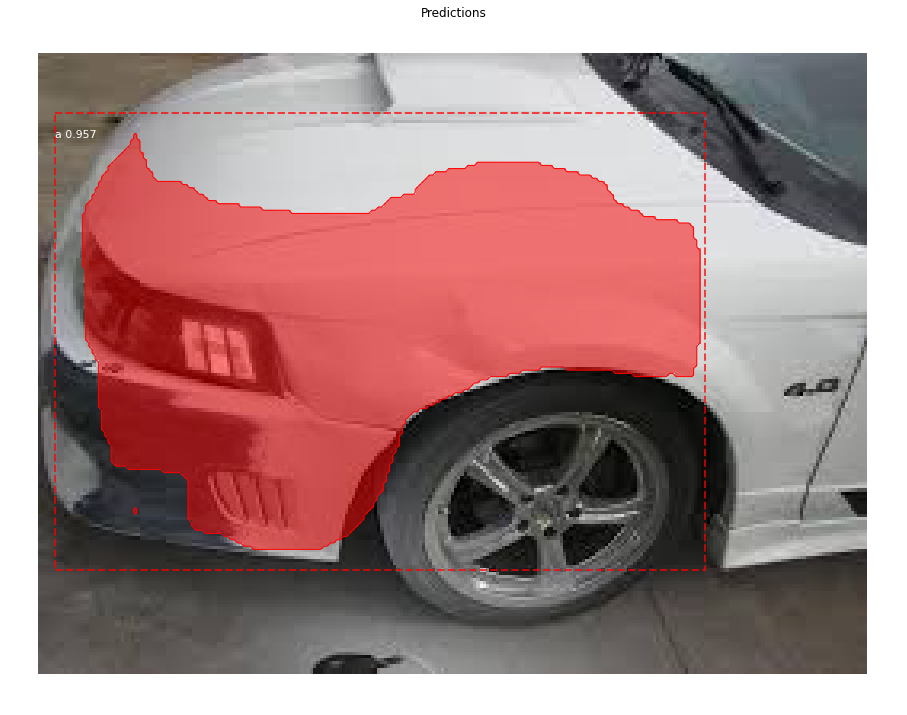

In [15]:
val_dir = CUSTOM_DIR + 'val/'
filelist = glob.glob(os.path.join(val_dir, '*.JPEG')) 

image_id = random.choice(filelist)
image = skimage.io.imread(image_id)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            'damage', r['scores'], ax=ax,
                            title="Predictions")